In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *
import seaborn as sns
import datetime
from scipy.stats import norm
sns.set(style="darkgrid")
import logging
import time

(wap-close)/(wap+close)

In [2]:
all_col = ['unique_symbol', 'date_time', 'close', 'turnover', 'open', 'high', 'low', 'volume',"use_tag", "adjustment", "adjustment_cumsum"]

In [3]:
params = {
    'task': 'train',
#     'booster': 'dart',
#     'boosting_type': 'gbdt',
#     'eta': 0.15,
    'max_depth': 6,
#     'lambda': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'gamma': 5,
#     'rate_drop': 0.1,
#     'skip_drop': 0.5,
    'nthread': 10,
    'alpha': 100
         }
num_rounds =1000
early = 30

In [110]:
# 训练日志
logger = logging.getLogger(__name__)
logger.setLevel(level = logging.INFO)
handler = logging.FileHandler("log/log" + str(time.ctime()) + ".txt")
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
logger.addHandler(handler)
logger.addHandler(console)

In [5]:
print("----------------- load and merge --------------------")
data = pd.read_csv('index500_v2_adjustment.csv', index_col=0)
data["date_time"]  = pd.to_datetime(data["date_time"])
data = data[all_col].copy()
data['wap'] = data['turnover']/data['volume']
data["adjustment"] =  data["adjustment"].fillna(0)


begin_interval_df = pd.read_csv('begin_930_interval_df.csv', index_col=0)
begin_interval_df["date_time"] = pd.to_datetime(begin_interval_df["date_time"])

index_df = pd.read_csv('index500_open.csv', index_col=0)
index_df["date_time"]  = pd.to_datetime(index_df["date_time"])

future_df = pd.read_csv('future500_open.csv', index_col=0)
future_df["date_time"]  = pd.to_datetime(future_df["date_time"])

data = pd.merge(data, begin_interval_df, how="left", on=['unique_symbol','date_time'])
data = pd.merge(data, index_df, how="left", on=['date_time'])
data = pd.merge(data, future_df, how="left", on=['date_time'])

----------------- load and merge --------------------


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
print(len(data))
print("---------------- shift data-------------------")
shift_day1 = 15
shift_day2 = 15
return_factor = []
vol_factor3 = []
vol_factor2 = []
vol_factor1 = []

shift_col = ['open', 'high', 'low', 'volume', 'turnover', 'wap']
gb_unique_symbol = data.groupby(["unique_symbol"])
for col in shift_col:
    for i in range(1, shift_day2):
        data[col + str(i)] = gb_unique_symbol[col].transform(lambda x: x.shift(i))
        print(col + str(i))      
        
for i in range(1, shift_day1):
    data['close' + str(i)] = gb_unique_symbol['close'].transform(lambda x: x.shift(i))
    data["adjustment_cumsum" + str(i)] = gb_unique_symbol["adjustment_cumsum"].transform(lambda x: x.shift(i))
    print('close' + str(i))        

4568036
---------------- shift data-------------------
open1
open2
open3
open4
open5
open6
open7
open8
open9
open10
open11
open12
open13
open14
high1
high2
high3
high4
high5
high6
high7
high8
high9
high10
high11
high12
high13
high14
low1
low2
low3
low4
low5
low6
low7
low8
low9
low10
low11
low12
low13
low14
volume1
volume2
volume3
volume4
volume5
volume6
volume7
volume8
volume9
volume10
volume11
volume12
volume13
volume14
turnover1
turnover2
turnover3
turnover4
turnover5
turnover6
turnover7
turnover8
turnover9
turnover10
turnover11
turnover12
turnover13
turnover14
wap1
wap2
wap3
wap4
wap5
wap6
wap7
wap8
wap9
wap10
wap11
wap12
wap13
wap14
close1
close2
close3
close4
close5
close6
close7
close8
close9
close10
close11
close12
close13
close14


In [7]:
print("---------------- return factor -------------------")
p_col = ['open', 'high', 'low', 'wap']    
for col in p_col:
    for i in range(1, shift_day2):
        data["r_" + col + str(i)] = (data[col + str(i)])/(data['close']  - data["adjustment_cumsum"] + data["adjustment_cumsum" + str(i)]) - 1
        return_factor.append("r_" + col + str(i))

for i in range(1, shift_day1):
    data["r_close" + str(i)] = (data['close' + str(i)])/(data['close']  - data["adjustment_cumsum"] + data["adjustment_cumsum" + str(i)]) - 1
    return_factor.append("r_close" + str(i))
    
v_col = ['turnover', 'volume']
for col in v_col:
    for i in range(1, shift_day2):
        data[col + str(i)] = data[col + str(i)] / data[col]
        vol_factor1.append(col + str(i))

---------------- return factor -------------------


In [8]:
for i in range(1, shift_day1):
    data["r_close1_square" + str(i)] = np.power(data["r_close" + str(i)], 2)
    return_factor.append("r_close1_square" + str(i))


data["r_close1_mean5"] = gb_unique_symbol["r_close1"].transform(lambda x: x.rolling(5).mean())
data["r_close1_mean9"] = gb_unique_symbol["r_close1"].transform(lambda x: x.rolling(9).mean())
data["r_close1_mean14"] = gb_unique_symbol["r_close1"].transform(lambda x: x.rolling(14).mean())
data["r_close1_sqrmean5"] = gb_unique_symbol["r_close1_square1"].transform(lambda x: x.rolling(5).mean())
data["r_close1_sqrmean9"] = gb_unique_symbol["r_close1_square1"].transform(lambda x: x.rolling(9).mean())
data["r_close1_sqrmean14"] = gb_unique_symbol["r_close1_square1"].transform(lambda x: x.rolling(14).mean())

In [9]:
data["max_wap"] = gb_unique_symbol["wap"].transform(lambda x: x.rolling(shift_day2).max())
data["min_wap"] = gb_unique_symbol["wap"].transform(lambda x: x.rolling(shift_day2).min())

In [10]:
# for factor_name in v_col:
#     for i in range(1, shift_day2):
#         print("sum_" + factor_name + str(i))
#         data["sum_" + factor_name + str(i)] = gb_unique_symbol[factor_name].transform(lambda x: x.rolling(window=i).sum())
#         vol_factor2.append("sum_" + factor_name + str(i))

In [11]:
data["close1_ema0.5"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 0.5).mean())
data["close1_ema1"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 1).mean())
data["close1_ema2"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 2).mean())
data["close1_ema5"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 5).mean())
data["close1_ema10"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 10).mean())
data["close1_ema20"] = gb_unique_symbol["r_close1"].transform(lambda x: x.ewm(halflife = 20).mean())

In [12]:
print("------------------- label \ set Universe--------------------")
data["t+1_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-1))
data["t+2_open"] = gb_unique_symbol["open"].transform(lambda x: x.shift(-2))
data['t+2_adjustment'] = gb_unique_symbol["adjustment"].transform(lambda x: x.shift(-2))
data['t+1_adjustment_cumsum'] = gb_unique_symbol['adjustment_cumsum'].transform(lambda x: x.shift(-1))

data["y_open"] = data["t+2_open"] - data['t+2_adjustment']
data['return'] = data['y_open'] / data['t+1_open'] - 1
data =  data[data["use_tag"] == 1].copy()

------------------- label \ set Universe--------------------


In [13]:
gb_date_time = data.groupby(['date_time'])
data['label'] = gb_date_time["return"].transform(lambda x: (x-x.mean())/x.std())
data['mr'] = gb_date_time["return"].transform(lambda x: x.mean())
data["cont"] = gb_date_time["unique_symbol"].transform(lambda x: x.count())
data["cont"] = data["cont"] + 1

In [14]:
for t,ddf in gb_date_time:
    print(t, len(ddf))

2010-01-29 00:00:00 492
2010-02-01 00:00:00 491
2010-02-02 00:00:00 493
2010-02-03 00:00:00 496
2010-02-04 00:00:00 497
2010-02-05 00:00:00 491
2010-02-08 00:00:00 488
2010-02-09 00:00:00 492
2010-02-10 00:00:00 495
2010-02-11 00:00:00 494
2010-02-12 00:00:00 497
2010-02-22 00:00:00 494
2010-02-23 00:00:00 492
2010-02-24 00:00:00 496
2010-02-25 00:00:00 491
2010-02-26 00:00:00 488
2010-03-01 00:00:00 486
2010-03-02 00:00:00 482
2010-03-03 00:00:00 490
2010-03-04 00:00:00 493
2010-03-05 00:00:00 487
2010-03-08 00:00:00 492
2010-03-09 00:00:00 495
2010-03-10 00:00:00 496
2010-03-11 00:00:00 497
2010-03-12 00:00:00 490
2010-03-15 00:00:00 494
2010-03-16 00:00:00 494
2010-03-17 00:00:00 493
2010-03-18 00:00:00 491
2010-03-19 00:00:00 487
2010-03-22 00:00:00 488
2010-03-23 00:00:00 490
2010-03-24 00:00:00 492
2010-03-25 00:00:00 482
2010-03-26 00:00:00 485
2010-03-29 00:00:00 487
2010-03-30 00:00:00 481
2010-03-31 00:00:00 478
2010-04-01 00:00:00 492
2010-04-02 00:00:00 481
2010-04-06 00:00

2011-07-29 00:00:00 484
2011-08-01 00:00:00 485
2011-08-02 00:00:00 489
2011-08-03 00:00:00 488
2011-08-04 00:00:00 489
2011-08-05 00:00:00 483
2011-08-08 00:00:00 481
2011-08-09 00:00:00 488
2011-08-10 00:00:00 488
2011-08-11 00:00:00 488
2011-08-12 00:00:00 482
2011-08-15 00:00:00 485
2011-08-16 00:00:00 482
2011-08-17 00:00:00 481
2011-08-18 00:00:00 482
2011-08-19 00:00:00 484
2011-08-22 00:00:00 485
2011-08-23 00:00:00 488
2011-08-24 00:00:00 483
2011-08-25 00:00:00 484
2011-08-26 00:00:00 486
2011-08-29 00:00:00 491
2011-08-30 00:00:00 486
2011-08-31 00:00:00 481
2011-09-01 00:00:00 487
2011-09-02 00:00:00 481
2011-09-05 00:00:00 482
2011-09-06 00:00:00 478
2011-09-07 00:00:00 490
2011-09-08 00:00:00 483
2011-09-09 00:00:00 486
2011-09-13 00:00:00 481
2011-09-14 00:00:00 490
2011-09-15 00:00:00 482
2011-09-16 00:00:00 476
2011-09-19 00:00:00 488
2011-09-20 00:00:00 484
2011-09-21 00:00:00 489
2011-09-22 00:00:00 485
2011-09-23 00:00:00 489
2011-09-26 00:00:00 490
2011-09-27 00:00

2013-03-07 00:00:00 493
2013-03-08 00:00:00 493
2013-03-11 00:00:00 494
2013-03-12 00:00:00 495
2013-03-13 00:00:00 494
2013-03-14 00:00:00 493
2013-03-15 00:00:00 491
2013-03-18 00:00:00 492
2013-03-19 00:00:00 494
2013-03-20 00:00:00 492
2013-03-21 00:00:00 494
2013-03-22 00:00:00 494
2013-03-25 00:00:00 492
2013-03-26 00:00:00 491
2013-03-27 00:00:00 491
2013-03-28 00:00:00 490
2013-03-29 00:00:00 491
2013-04-01 00:00:00 495
2013-04-02 00:00:00 495
2013-04-03 00:00:00 495
2013-04-08 00:00:00 494
2013-04-09 00:00:00 494
2013-04-10 00:00:00 493
2013-04-11 00:00:00 492
2013-04-12 00:00:00 494
2013-04-15 00:00:00 493
2013-04-16 00:00:00 493
2013-04-17 00:00:00 494
2013-04-18 00:00:00 493
2013-04-19 00:00:00 493
2013-04-22 00:00:00 494
2013-04-23 00:00:00 493
2013-04-24 00:00:00 492
2013-04-25 00:00:00 493
2013-04-26 00:00:00 493
2013-05-02 00:00:00 492
2013-05-03 00:00:00 492
2013-05-06 00:00:00 490
2013-05-07 00:00:00 492
2013-05-08 00:00:00 492
2013-05-09 00:00:00 493
2013-05-10 00:00

2014-09-23 00:00:00 475
2014-09-24 00:00:00 476
2014-09-25 00:00:00 476
2014-09-26 00:00:00 473
2014-09-29 00:00:00 473
2014-09-30 00:00:00 479
2014-10-08 00:00:00 477
2014-10-09 00:00:00 478
2014-10-10 00:00:00 477
2014-10-13 00:00:00 474
2014-10-14 00:00:00 473
2014-10-15 00:00:00 475
2014-10-16 00:00:00 474
2014-10-17 00:00:00 473
2014-10-20 00:00:00 474
2014-10-21 00:00:00 471
2014-10-22 00:00:00 470
2014-10-23 00:00:00 467
2014-10-24 00:00:00 467
2014-10-27 00:00:00 466
2014-10-28 00:00:00 468
2014-10-29 00:00:00 468
2014-10-30 00:00:00 465
2014-10-31 00:00:00 467
2014-11-03 00:00:00 467
2014-11-04 00:00:00 464
2014-11-05 00:00:00 464
2014-11-06 00:00:00 466
2014-11-07 00:00:00 466
2014-11-10 00:00:00 461
2014-11-11 00:00:00 462
2014-11-12 00:00:00 463
2014-11-13 00:00:00 463
2014-11-14 00:00:00 463
2014-11-17 00:00:00 463
2014-11-18 00:00:00 461
2014-11-19 00:00:00 458
2014-11-20 00:00:00 455
2014-11-21 00:00:00 457
2014-11-24 00:00:00 458
2014-11-25 00:00:00 459
2014-11-26 00:00

2016-04-12 00:00:00 465
2016-04-13 00:00:00 465
2016-04-14 00:00:00 465
2016-04-15 00:00:00 464
2016-04-18 00:00:00 465
2016-04-19 00:00:00 462
2016-04-20 00:00:00 460
2016-04-21 00:00:00 459
2016-04-22 00:00:00 458
2016-04-25 00:00:00 459
2016-04-26 00:00:00 459
2016-04-27 00:00:00 460
2016-04-28 00:00:00 463
2016-04-29 00:00:00 464
2016-05-03 00:00:00 465
2016-05-04 00:00:00 467
2016-05-05 00:00:00 468
2016-05-06 00:00:00 468
2016-05-09 00:00:00 466
2016-05-10 00:00:00 468
2016-05-11 00:00:00 468
2016-05-12 00:00:00 465
2016-05-13 00:00:00 464
2016-05-16 00:00:00 466
2016-05-17 00:00:00 467
2016-05-18 00:00:00 468
2016-05-19 00:00:00 467
2016-05-20 00:00:00 467
2016-05-23 00:00:00 466
2016-05-24 00:00:00 466
2016-05-25 00:00:00 466
2016-05-26 00:00:00 466
2016-05-27 00:00:00 465
2016-05-30 00:00:00 466
2016-05-31 00:00:00 466
2016-06-01 00:00:00 465
2016-06-02 00:00:00 464
2016-06-03 00:00:00 465
2016-06-06 00:00:00 466
2016-06-07 00:00:00 467
2016-06-08 00:00:00 467
2016-06-13 00:00

2017-10-27 00:00:00 478
2017-10-30 00:00:00 477
2017-10-31 00:00:00 479
2017-11-01 00:00:00 479
2017-11-02 00:00:00 480
2017-11-03 00:00:00 480
2017-11-06 00:00:00 480
2017-11-07 00:00:00 480
2017-11-08 00:00:00 480
2017-11-09 00:00:00 480
2017-11-10 00:00:00 480
2017-11-13 00:00:00 479
2017-11-14 00:00:00 479
2017-11-15 00:00:00 479
2017-11-16 00:00:00 478
2017-11-17 00:00:00 477
2017-11-20 00:00:00 478
2017-11-21 00:00:00 476
2017-11-22 00:00:00 474
2017-11-23 00:00:00 472
2017-11-24 00:00:00 469
2017-11-27 00:00:00 468
2017-11-28 00:00:00 468
2017-11-29 00:00:00 470
2017-11-30 00:00:00 468
2017-12-01 00:00:00 468
2017-12-04 00:00:00 469
2017-12-05 00:00:00 470
2017-12-06 00:00:00 470
2017-12-07 00:00:00 469
2017-12-08 00:00:00 470
2017-12-11 00:00:00 471
2017-12-12 00:00:00 469
2017-12-13 00:00:00 469
2017-12-14 00:00:00 473
2017-12-15 00:00:00 473
2017-12-18 00:00:00 470
2017-12-19 00:00:00 470
2017-12-20 00:00:00 470
2017-12-21 00:00:00 469
2017-12-22 00:00:00 470
2017-12-25 00:00

In [15]:
print("---------------- add factor--------------------")
data["r1"]  = (data["t+1_close_mid"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["close"] -1
data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
data["amplitude_ratio"] =  abs((data["close"] - data["open"])/(data["high"] - data["low"]))
data["amplitude_ratio"] =  data["amplitude_ratio"].fillna(0)
data["Volatility_15d"] = data["max_wap"] / data["min_wap"] -1

---------------- add factor--------------------


In [16]:
# print("----------------- stationary --------------------")
# vol_factor3 = []
# for factor_name in v_col:
#     for i in range(1, shift_day2):
#         print("norm_" + factor_name + str(i))
#         data["norm_" + factor_name + str(i)] = gb_date_time["sum_" + factor_name + str(i)].transform(lambda x: x.rank())
#         data["norm_" + factor_name + str(i)] = data["norm_" + factor_name + str(i)] / data["cont"]
#         data["norm_" + factor_name + str(i)] = data["norm_" + factor_name + str(i)].apply(lambda x: InverseNormalCDF(x))
#         vol_factor3.append("norm_" + factor_name + str(i))

In [17]:
print("----------------- stationary --------------------")

data["r_distribute"] = gb_date_time["r"].transform(lambda x: (x-x.mean())/x.std())
data["r1_distribute"] = gb_date_time["r1"].transform(lambda x: (x-x.mean())/x.std())
data['open_demean'] = gb_date_time["open"].transform(lambda x: (x-x.mean())/x.std())

data["close_rank"] = gb_date_time['close'].transform( lambda x:x.rank())
data["close_Normal"] = data["close_rank"] / data["cont"]
data["close_Normal"] = data["close_Normal"].apply(lambda x: InverseNormalCDF(x))

data['close_demean'] = gb_date_time["close"].transform(lambda x: (x-x.mean())/x.std())
data["close1_ema5_demean"] = gb_date_time["close1_ema5"].transform(lambda x: (x-x.mean())/x.std())
data["close1_ema10_demean"] = gb_date_time["close1_ema10"].transform(lambda x: (x-x.mean())/x.std())
data["close1_ema20_demean"] = gb_date_time["close1_ema20"].transform(lambda x: (x-x.mean())/x.std())



data["turnover_rank"] = gb_date_time['turnover'].transform( lambda x:x.rank())
data["turnover_norm"] = data["turnover_rank"] / data["cont"]
data["turnover_norm"] = data["turnover_norm"].apply(lambda x: InverseNormalCDF(x))

data["volume_rank"] = gb_date_time['volume'].transform( lambda x:x.rank())
data["volume_norm"] = data["volume_rank"] / data["cont"]
data["volume_norm"] = data["volume_norm"].apply(lambda x: InverseNormalCDF(x))


data["Volatility_15d_rank"] = gb_date_time['Volatility_15d'].transform( lambda x:x.rank())
data["Volatility_15d_rank"] = data["Volatility_15d_rank"] / data["cont"]
data["Volatility_15d_norm"] = data["Volatility_15d_rank"].apply(lambda x: InverseNormalCDF(x))

----------------- stationary --------------------


In [18]:
print("----------------- stationary --------------------")
return_factor2 = []
for i in range(1, shift_day2):
    data[ "r_close" + str(i) + "_demean"] =  gb_date_time["r_close" + str(i)].transform(lambda x: x-x.mean())
    data[ "r_close" + str(i) + "_uniform"] =  gb_date_time["r_close" + str(i)].transform(lambda x: x.rank())
    data[ "r_close" + str(i) + "_uniform"] =  data[ "r_close" + str(i) + "_uniform"] / data["cont"]
    return_factor2.append("r_close" + str(i) + "_uniform")   

----------------- stationary --------------------


In [19]:
print(data["label"].mean()) 
data = data[~data['return'].isnull()].copy()
print(data["label"].mean())  

1.6010549261784694e-18
1.4961314237347347e-18


In [20]:
intraday_factor = ["r","r_distribute", 'close_demean', 'open_demean', 'turnover_norm', "volume_norm", "amplitude_ratio","close_Normal"]
r1_factor = ["r1","r1_distribute"]
use_f = []
use_f = r1_factor + return_factor + intraday_factor
print("r1_factor:  ", r1_factor, "\n")
print("return_factor:  ", return_factor, "\n")
print("intraday_factor:   ", intraday_factor, "\n")
print("vol_factor1:  ", vol_factor1, "\n")
print("vol_factor2:  ", vol_factor2, "\n")

r1_factor:   ['r1', 'r1_distribute'] 

return_factor:   ['r_open1', 'r_open2', 'r_open3', 'r_open4', 'r_open5', 'r_open6', 'r_open7', 'r_open8', 'r_open9', 'r_open10', 'r_open11', 'r_open12', 'r_open13', 'r_open14', 'r_high1', 'r_high2', 'r_high3', 'r_high4', 'r_high5', 'r_high6', 'r_high7', 'r_high8', 'r_high9', 'r_high10', 'r_high11', 'r_high12', 'r_high13', 'r_high14', 'r_low1', 'r_low2', 'r_low3', 'r_low4', 'r_low5', 'r_low6', 'r_low7', 'r_low8', 'r_low9', 'r_low10', 'r_low11', 'r_low12', 'r_low13', 'r_low14', 'r_wap1', 'r_wap2', 'r_wap3', 'r_wap4', 'r_wap5', 'r_wap6', 'r_wap7', 'r_wap8', 'r_wap9', 'r_wap10', 'r_wap11', 'r_wap12', 'r_wap13', 'r_wap14', 'r_close1', 'r_close2', 'r_close3', 'r_close4', 'r_close5', 'r_close6', 'r_close7', 'r_close8', 'r_close9', 'r_close10', 'r_close11', 'r_close12', 'r_close13', 'r_close14', 'r_close1_square1', 'r_close1_square2', 'r_close1_square3', 'r_close1_square4', 'r_close1_square5', 'r_close1_square6', 'r_close1_square7', 'r_close1_square8', 'r

In [21]:
shift1 = 15
shift2 = 5
rf_row1 = ["r_close" + str(i) for i in range(1,shift1)]
rf_row2 = ["r_open" + str(i) for i in range(1,shift1)]
rf_row3 = ["r_low" + str(i) for i in range(1,shift1)]
rf_row4 = ["r_high" + str(i) for i in range(1,shift1)]
rf_row5 = ["r_wap" + str(i) for i in range(1,shift1)]
rf_row = rf_row1 + rf_row2 + rf_row3 + rf_row4 + rf_row5

In [22]:
tl1 = ["r_close" + str(i) for i in range(1,shift1)]
tl2 = ["r_open" + str(i) for i in range(1,shift2)]
tl3 = ["r_low" + str(i) for i in range(1,shift2)]
tl4 = ["r_high" + str(i) for i in range(1,shift2)]
tl5 = ["r_wap" + str(i) for i in range(1,shift2)]
rf = tl1 + tl2 + tl3 + tl4 + tl5
rf_square = ["r_close1_square" + str(i) for i in range(1, shift1)]
rf_demean = ["r_close" + str(i) + "_demean" for i in range(1, shift2)]
rf_uniform = ["r_close" + str(i) + "_uniform" for i in range(1, shift2)]
r3 = ["r_close1_mean9", "r_close1_sqrmean9","r_close1_mean14", "r_close1_sqrmean14"]
rema = [ "close1_ema10", "close1_ema20"]

In [23]:
use_f = rf + rf_uniform + rf_demean + rf_square +  r3 + rema +  intraday_factor + r1_factor + vol_factor1

In [24]:
print(use_f)
print(len(use_f))

['r_close1', 'r_close2', 'r_close3', 'r_close4', 'r_close5', 'r_close6', 'r_close7', 'r_close8', 'r_close9', 'r_close10', 'r_close11', 'r_close12', 'r_close13', 'r_close14', 'r_open1', 'r_open2', 'r_open3', 'r_open4', 'r_low1', 'r_low2', 'r_low3', 'r_low4', 'r_high1', 'r_high2', 'r_high3', 'r_high4', 'r_wap1', 'r_wap2', 'r_wap3', 'r_wap4', 'r_close1_uniform', 'r_close2_uniform', 'r_close3_uniform', 'r_close4_uniform', 'r_close1_demean', 'r_close2_demean', 'r_close3_demean', 'r_close4_demean', 'r_close1_square1', 'r_close1_square2', 'r_close1_square3', 'r_close1_square4', 'r_close1_square5', 'r_close1_square6', 'r_close1_square7', 'r_close1_square8', 'r_close1_square9', 'r_close1_square10', 'r_close1_square11', 'r_close1_square12', 'r_close1_square13', 'r_close1_square14', 'r_close1_mean9', 'r_close1_sqrmean9', 'r_close1_mean14', 'r_close1_sqrmean14', 'close1_ema10', 'close1_ema20', 'r', 'r_distribute', 'close_demean', 'open_demean', 'turnover_norm', 'volume_norm', 'amplitude_ratio', 'c

In [25]:
print("-------------------- split dataset -----------------------")
for i in range(1):
    
    t1 = datetime.datetime(2010,1,1)
    t2 = datetime.datetime(2014,6,1)
    t3 = datetime.datetime(2015,6,1)
#     t2 = datetime.datetime(2013,1,1)
#     t3 = datetime.datetime(2015,1,1)
    t4 = datetime.datetime(2018,1,1)
    data_tr = data[ (data["date_time"] >= t1) & (data["date_time"] < t2)]
    data_te = data[ (data["date_time"] >= t2) & (data["date_time"] < t3)]
    data_fin = data[ (data["date_time"] >= t3) & (data["date_time"] < t4)]
    print(len(data_tr["date_time"]))
    print(len(data_te["date_time"]))
    print(len(data_fin["date_time"]))
    
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

-------------------- split dataset -----------------------
508494
113959
291768


In [26]:
print("-------------------- train -----------------------")
market_return = list(data[data["date_time"].isin(list(data_fin.date_time))].groupby(['date_time'])['return'].mean())
bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  
importance_dic = f_importance(bst, use_f)

-------------------- train -----------------------


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:1.05645	eval-rmse:1.0552
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 30 rounds.
[1]	train-rmse:1.02481	eval-rmse:1.02335
[2]	train-rmse:1.00838	eval-rmse:1.00734
[3]	train-rmse:0.999787	eval-rmse:0.999414
[4]	train-rmse:0.995214	eval-rmse:0.995411
[5]	train-rmse:0.992391	eval-rmse:0.993632
[6]	train-rmse:0.990626	eval-rmse:0.992672
[7]	train-rmse:0.989542	eval-rmse:0.992227
[8]	train-rmse:0.988534	eval-rmse:0.992175
[9]	train-rmse:0.987993	eval-rmse:0.992023
[10]	train-rmse:0.987447	eval-rmse:0.992094
[11]	train-rmse:0.986933	eval-rmse:0.991969
[12]	train-rmse:0.986298	eval-rmse:0.991991
[13]	train-rmse:0.985971	eval-rmse:0.991961
[14]	train-rmse:0.985552	eval-rmse:0.991887
[15]	train-rmse:0.98519	eval-rmse:0.991779
[16]	train-rmse:0.984677	eval-rmse:0.991916
[17]	train-rmse:0.984282	eval-rmse:0.991836
[18]	train-rmse:0.983838	eval-rmse:0.991833
[19]	train-rmse:0.983562	eval-rmse:0.99

In [69]:
tree_nums = bst.best_ntree_limit + 20
preds = bst.predict(xgb.DMatrix(data_fin[use_f]), ntree_limit=tree_nums)
data_fin["preds"] = list(preds)
preds = bst.predict(xgb.DMatrix(data_te[use_f]), ntree_limit=tree_nums)
data_te["preds"] = list(preds)
preds = bst.predict(xgb.DMatrix(data_tr[use_f]), ntree_limit=tree_nums)
data_tr["preds"] = list(preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [70]:
gb = data_fin.groupby(['date_time'])['preds']
data_fin["pred_mean"] = gb.transform(lambda x: x.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
t1 = datetime.datetime(2017,2,25)
t2 = datetime.datetime(2017,3,25)
df = data_fin[(data_fin["date_time"]>= t1) & (data_fin["date_time"]<= t2)]
np.corrcoef(df["return"] - df["mr"] , df["preds"] - df["pred_mean"])[0,1]

0.10979699315202336

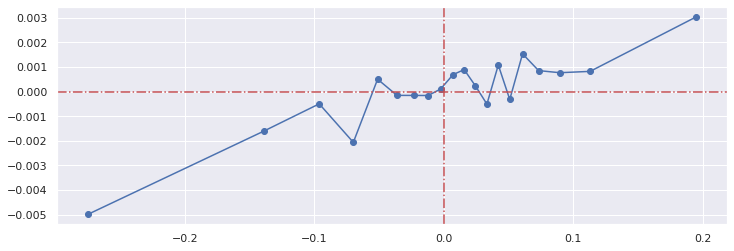

,bin_cut,x,y
0,"(-1.0199999999999998, -0.172]",-0.274959,-0.004984
1,"(-0.172, -0.114]",-0.139090,-0.001608
2,"(-0.114, -0.0813]",-0.096206,-0.000500
3,"(-0.0813, -0.06]",-0.069881,-0.002061
4,"(-0.06, -0.044]",-0.051129,0.000499
5,"(-0.044, -0.029]",-0.036186,-0.000157
6,"(-0.029, -0.0173]",-0.022901,-0.000158
7,"(-0.0173, -0.00757]",-0.012169,-0.000162
8,"(-0.00757, 0.0024]",-0.002480,0.000100
9,"(0.0024, 0.0114]",0.007144,0.000685


In [72]:
plot_conditional_expectation(np.array(df["preds"] - df["pred_mean"]), np.array(df["return"]) - np.array(df["mr"]))

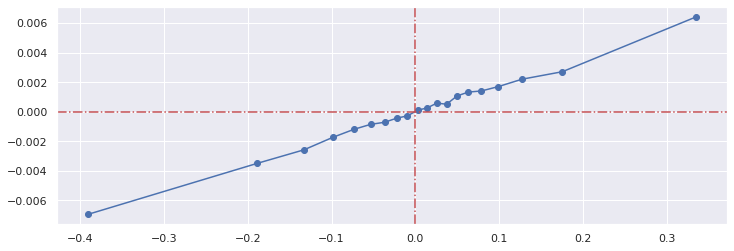

,bin_cut,x,y
0,"(-1.587, -0.233]",-0.390943,-0.006960
1,"(-0.233, -0.156]",-0.189177,-0.003508
2,"(-0.156, -0.114]",-0.133032,-0.002584
3,"(-0.114, -0.0848]",-0.098488,-0.001736
4,"(-0.0848, -0.0626]",-0.073226,-0.001192
5,"(-0.0626, -0.0448]",-0.053457,-0.000859
6,"(-0.0448, -0.0294]",-0.036876,-0.000718
7,"(-0.0294, -0.0158]",-0.022546,-0.000443
8,"(-0.0158, -0.00343]",-0.009468,-0.000280
9,"(-0.00343, 0.0084]",0.002556,0.000100


In [73]:
plot_conditional_expectation( np.array(data_fin["preds"]-data_fin["pred_mean"]),np.array(data_fin["return"])-np.array(data_fin["mr"]))

In [74]:
# sns.jointplot(
#               x = data_fin["preds"], y = data_fin["return"], 
#               data = data_fin,  #设置数据                                 
#               kind="reg",                                     
#               size = 8, #图表大小(自动调整为正方形))             
#               ratio = 5, #散点图与布局图高度比，整型             
#               marginal_kws = dict(bins=15, rug =True),              
#              )

In [75]:
for y in range(2015,2018):
    temp_df = data_fin[data_fin["date_time"].dt.year == y ]
    print(y, np.corrcoef(temp_df["return"] - temp_df["mr"], temp_df["preds"] - temp_df["pred_mean"])[0,1])

2015 0.12883547046068922
2016 0.14195609879335241
2017 0.1025600681928901


In [76]:
logger.info(np.corrcoef(data_fin["return"] - data_fin["mr"] , data_fin["preds"] - data_fin["pred_mean"])[0,1])

0.12616109741373605


In [77]:
logger.info("dmarketmean_corrcoef(test)")
logger.info(np.corrcoef(data_fin["return"] - data_fin["mr"] , data_fin["preds"])[0,1])

dmarketmean_corrcoef(test)
0.11484525576950164


In [36]:
logger.info("dmarketmean_corrcoef(val)")
logger.info(np.corrcoef(data_te["return"] - data_te["mr"] , data_te["preds"])[0,1])

dmarketmean_corrcoef(val)
0.13344277486798684


In [37]:
logger.info("dmarketmean_corrcoef(train)")
logger.info(np.corrcoef(data_tr["return"] - data_tr["mr"] , data_tr["preds"])[0,1])

dmarketmean_corrcoef(train)
0.19917361248270163


In [38]:
gb = data_fin.groupby(["unique_symbol"])
auto_corr = []
real_auto_corr = []
for _,frame in gb:
    l1 = list(frame["preds"].shift(1))[1:]
    l2 = list(frame["preds"])[1:]
    r1 = list(frame["return"].shift(1))[1:]
    r2 = list(frame["return"])[1:]
    corr = np.corrcoef(l1, l2)[0,1]
    re_corr = np.corrcoef(r1, r2)[0,1]
    auto_corr.append(corr)
    real_auto_corr.append(re_corr)
print("pred auto corr:", np.mean(auto_corr))
print("return auto corr:", np.mean(real_auto_corr))

pred auto corr: 0.20236029649501633
return auto corr: -0.029180227993966818


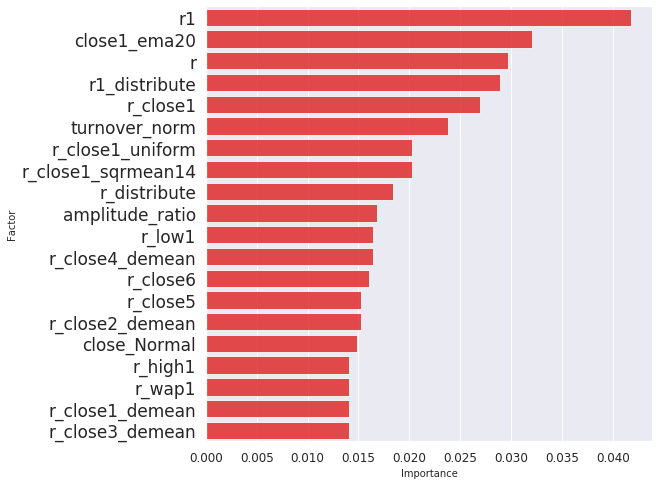

In [39]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.tick_params(labelsize=12)
f_importance_bar(importance_dic)

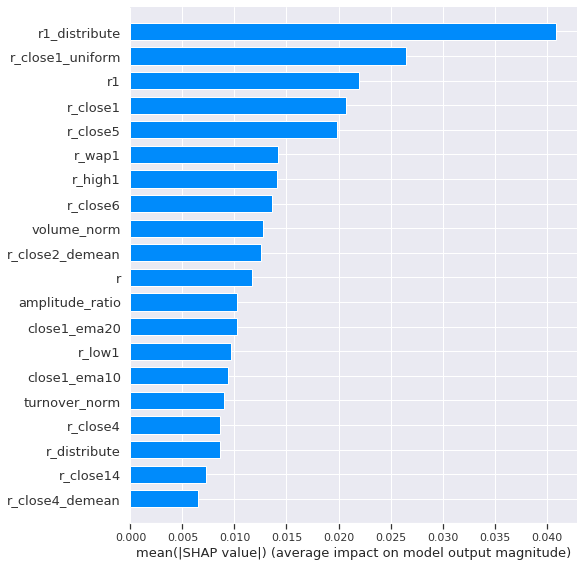

In [40]:
import shap
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_tr[use_f])
shap.summary_plot(shap_values, data[use_f], plot_type="bar")

In [41]:
df_tree = bst.trees_to_dataframe()

In [42]:
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(data_te[use_f+["label"]].corr(), cmap=cmap, annot =True)

In [43]:
all_tree_rounds = bst.best_ntree_limit + early
tr_step = []
te_step = []
fin_step = []
for i in range(1, all_tree_rounds):
    if i % 5==0:
        print("Tree numbers：" ,i ,"best_ntree_limit:", bst.best_ntree_limit, "early_stop:", early)
    temp1 = bst.predict( xgb.DMatrix(data_tr[use_f]),ntree_limit= i)
    temp2 = bst.predict( xgb.DMatrix(data_te[use_f]),ntree_limit= i)
    temp3 = bst.predict( xgb.DMatrix(data_fin[use_f]),ntree_limit= i)
    corrcoef1 = np.corrcoef(temp1, data_tr["return"] - data_tr["mr"])[0,1]
    corrcoef2 = np.corrcoef(temp2, data_te["return"] - data_te["mr"])[0,1]
    corrcoef3 = np.corrcoef(temp3, data_fin["return"] - data_fin["mr"])[0,1]
    tr_rmse = ((temp1 - data_tr["label"])*(temp1 - data_tr["label"])).mean()
    te_rmse = ((temp2 - data_te["label"])*(temp2 - data_te["label"])).mean()
    fin_rmse = ((temp3 - data_fin["label"])*(temp3 - data_fin["label"])).mean()
    tr_step.append([tr_rmse, corrcoef1])
    te_step.append([te_rmse, corrcoef2])
    fin_step.append([fin_rmse, corrcoef3])

Tree numbers： 5 best_ntree_limit: 26 early_stop: 30
Tree numbers： 10 best_ntree_limit: 26 early_stop: 30
Tree numbers： 15 best_ntree_limit: 26 early_stop: 30
Tree numbers： 20 best_ntree_limit: 26 early_stop: 30
Tree numbers： 25 best_ntree_limit: 26 early_stop: 30
Tree numbers： 30 best_ntree_limit: 26 early_stop: 30
Tree numbers： 35 best_ntree_limit: 26 early_stop: 30
Tree numbers： 40 best_ntree_limit: 26 early_stop: 30
Tree numbers： 45 best_ntree_limit: 26 early_stop: 30
Tree numbers： 50 best_ntree_limit: 26 early_stop: 30
Tree numbers： 55 best_ntree_limit: 26 early_stop: 30


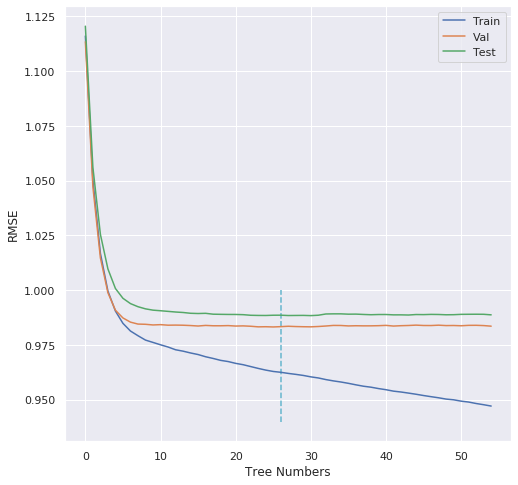

In [44]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,0], label="Train")
plt.plot(np.array(te_step)[:,0], label="Val")
plt.plot(np.array(fin_step)[:,0], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("RMSE")
plt.vlines(bst.best_ntree_limit, 0.94, 1, colors = "c", linestyles = "dashed")
plt.legend()

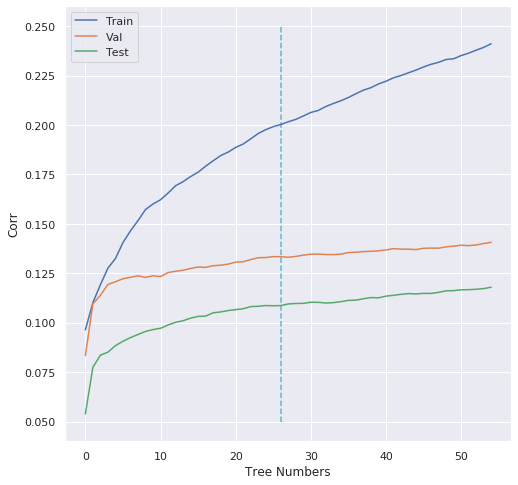

In [45]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(np.array(tr_step)[:,1], label="Train")
plt.plot(np.array(te_step)[:,1], label="Val")
plt.plot(np.array(fin_step)[:,1], label="Test")
plt.xlabel("Tree Numbers")
plt.ylabel("Corr")
plt.vlines(bst.best_ntree_limit, 0.05, 0.25, colors = "c", linestyles = "dashed")
plt.legend()

In [46]:
all_tree_rounds = bst.best_ntree_limit + early
zero = []
leave_node = []
tree_node = []
for tree_id in range(1, all_tree_rounds):
    zero.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf") & (df_tree["Gain"] == 0)].shape[0])
    leave_node.append(df_tree[(df_tree["Tree"] == tree_id)  & (df_tree["Feature"] == "Leaf")].shape[0])
    tree_node.append(df_tree[(df_tree["Tree"] == tree_id)].shape[0])

[<matplotlib.lines.Line2D at 0x7f4fe08e8b70>]

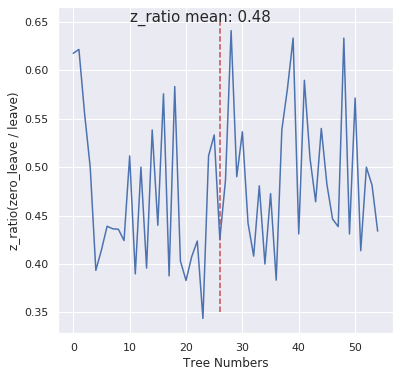

In [47]:
zero = np.array(zero)
plt.rcParams['figure.figsize'] = (6, 6)
leave_node = np.array(leave_node)
tree_node = np.array(tree_node)
plt.vlines(bst.best_ntree_limit, 0.35, 0.65, colors = "r", linestyles = "dashed")
plt.xlabel("Tree Numbers")
plt.ylabel("z_ratio(zero_leave / leave)")
zr = np.mean(zero/leave_node)
plt.text(10, 0.65, r"z_ratio mean: %.2f" %(zr) , fontsize=15)
plt.plot(zero/leave_node)

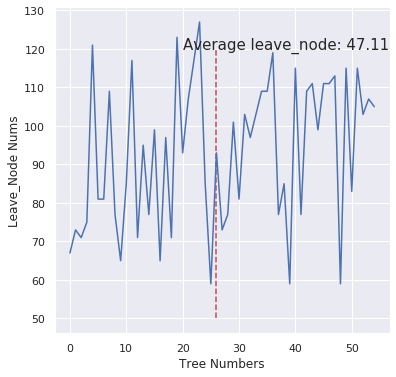

In [48]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.text(20, 120, r"Average leave_node: %.2f" %(np.mean(leave_node)) , fontsize=15)
plt.xlabel("Tree Numbers")
plt.ylabel("Leave_Node Nums")
plt.plot(tree_node)
plt.vlines(bst.best_ntree_limit, 50, 120, colors = "r", linestyles = "dashed")

In [90]:
tb = datetime.datetime(2015,7,1)
te = datetime.datetime(2018,1,1)
data_sim = data[ (data["date_time"] >= tb)&(data["date_time"] < te)]
sim_pred =  bst.predict(xgb.DMatrix(data_sim[use_f]), ntree_limit= bst.best_ntree_limit + 20)

In [91]:
data_sim["preds"] = sim_pred
data_sim = data_sim.reset_index(drop=True)
gb = data_sim.groupby(['date_time'])['preds']
data_sim["pred_mean"] = gb.transform(lambda x: x.mean())
data_sim["preds"] = data_sim["preds"] - data_sim["pred_mean"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


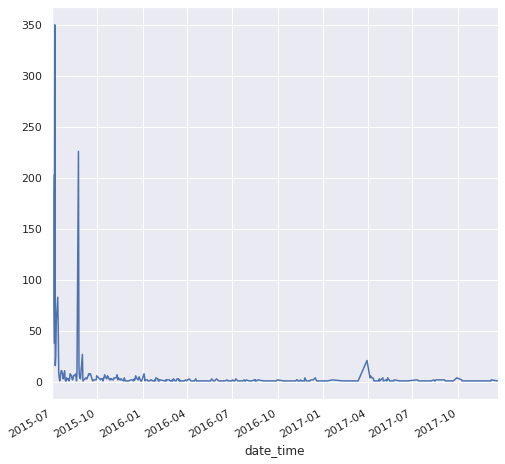

In [92]:
data_sim[(data_sim["r1"]<-0.099) | (data_sim["r1"]>0.099)].groupby(["date_time"])["unique_symbol"].count().plot()

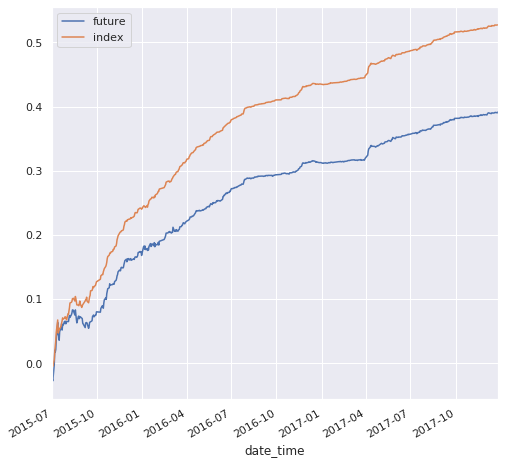

In [93]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

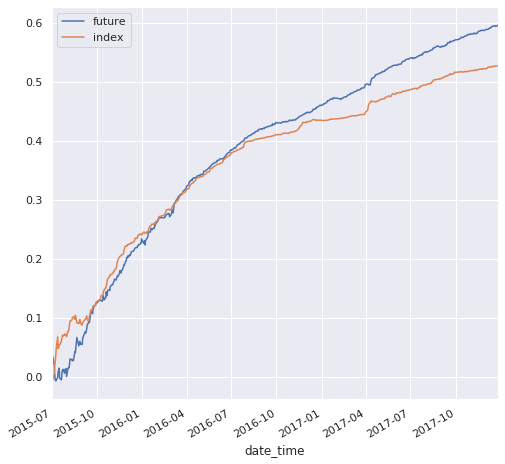

In [94]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

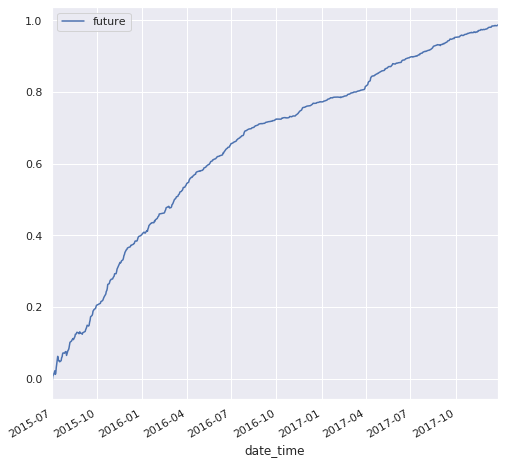

In [95]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

In [56]:
# gb = data_sim.groupby(["unique_symbol"])
# data_sim["yesterday_preds"] = gb["preds"].shift(1)
# data_sim["preds"] = data_sim.apply(lambda x: min(x["preds"], x["yesterday_preds"]) if x["r1"] >= 0.099 else x["preds"], axis=1)
# data_sim["preds"] = data_sim.apply(lambda x: max(x["preds"], x["yesterday_preds"]) if x["r1"] <= -0.099 else x["preds"], axis=1)

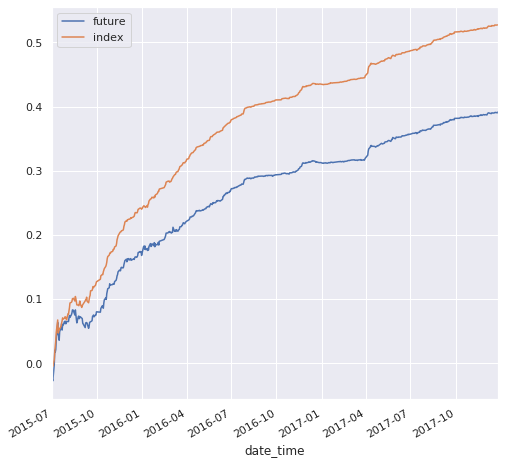

In [96]:
data_sim["preds+"] = data_sim["preds"].apply(lambda x: x if x>=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["future500_return"])
data_sim["pnl_byweightI1"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
pnl_byweightF1 = data_sim.groupby(['date_time'])['pnl_byweightF1'].sum()*0.008
pnl_byweightI1 = data_sim.groupby(['date_time'])['pnl_byweightI1'].sum()*0.008
pnl_byweightF1.cumsum().plot(label = "future")
pnl_byweightI1.cumsum().plot(label = "index")
plt.legend()

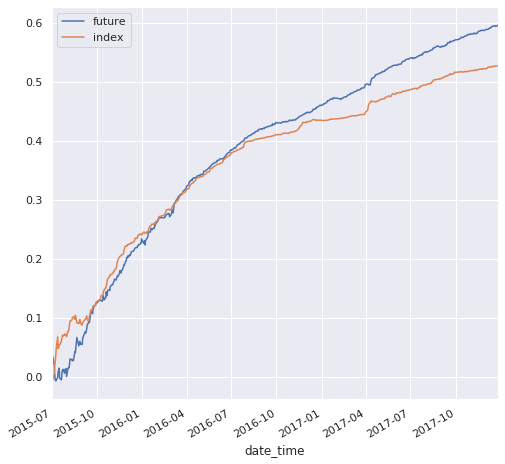

In [97]:
data_sim["preds-"] = data_sim["preds"].apply(lambda x: x if x<=0 else 0)
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightI2"] = data_sim["preds+"] * (data_sim["return"] - data_sim["index500_return"])
data_sim["pnl_byweightF2"] =  data_sim["preds-"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF2 = data_sim.groupby(['date_time'])['pnl_byweightF2'].sum()*0.008
pnl_byweightI2 = data_sim.groupby(['date_time'])['pnl_byweightI2'].sum()*0.008
pnl_byweightF2.cumsum().plot(label = "future")
pnl_byweightI2.cumsum().plot(label = "index")
plt.legend()

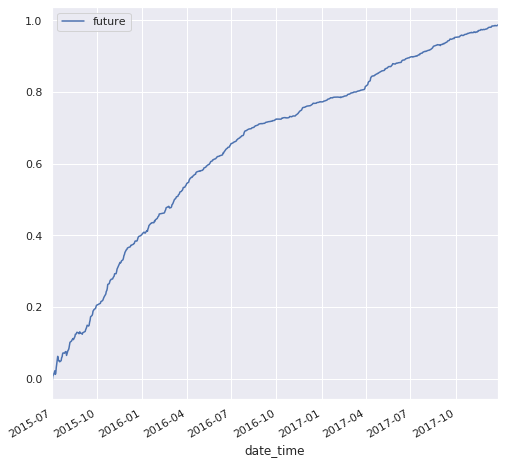

In [98]:
plt.rcParams['figure.figsize'] = (8, 8)
data_sim["pnl_byweightF"] = data_sim["preds"] * (data_sim["return"] - data_sim["future500_return"])
pnl_byweightF = data_sim.groupby(['date_time'])['pnl_byweightF'].sum()*0.008
pnl_byweightF.cumsum().plot(label = "future")
plt.legend()

In [99]:
sim_df = data_sim[["date_time","preds","unique_symbol"]].copy()

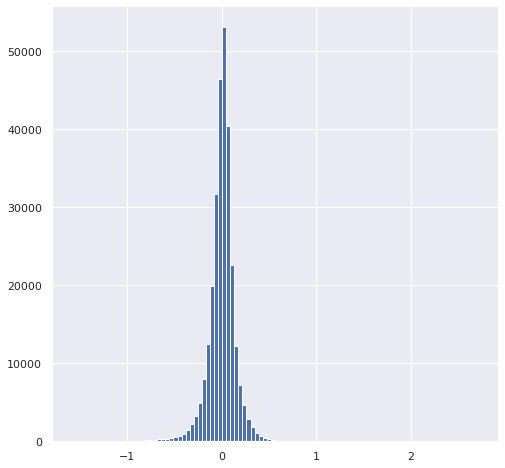

In [100]:
data_sim["preds"].hist(bins= 100)

In [101]:
data_sim.loc[data_sim["preds"].argmin():][["unique_symbol","preds","label","return","r1","date_time"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


,unique_symbol,preds,label,return,r1,date_time
126037,652,-1.585628,-1.330977,-0.021538,7.986689e-02,2016-08-18
126038,656,-0.096850,0.457443,0.011111,-3.326180e-02,2016-08-18
126039,661,0.099492,-0.177554,-0.000481,4.822531e-05,2016-08-18
126040,690,-0.009229,0.186943,0.006173,-4.907975e-03,2016-08-18
126041,669,0.064024,0.667841,0.014952,2.097064e-03,2016-08-18
...,...,...,...,...,...,...
282586,300039,0.019765,0.335914,0.011513,-2.454992e-03,2017-12-27
282587,300043,0.073668,-0.498078,-0.003284,6.661338e-16,2017-12-27
282588,300001,0.028979,0.183957,0.008817,-1.101322e-03,2017-12-27
282589,300002,0.089701,-0.498078,-0.003284,1.998401e-15,2017-12-27


In [102]:
data_sim["preds"].quantile(q=0.8)

0.08596070110797882

In [103]:
def get_forecast(data_sim):
    
    data_sim["date_time"] = data_sim["date_time"] + datetime.timedelta(hours=9.5)
    data_sim["date_time"] = data_sim["date_time"].apply(lambda x:str(x))
    data_sim["unique_symbol"] = data_sim["unique_symbol"].apply(lambda x:str(x))
    data_sim["unique_symbol"]  = data_sim["unique_symbol"].apply(lambda x: x if len(x)==6 else (6-len(x))*"0"+x)
    data_sim["unique_symbol"]  = data_sim["unique_symbol"].apply(lambda x: str(104060)+x)
    data_sim = data_sim.reset_index(drop = True)
    symbol = sorted(list(set(data_sim["unique_symbol"])))
    timestamp = sorted(list(set(data_sim["date_time"])))
    forecast = []
    for s in range(len(symbol)):
        forecast.append(np.array([0]*len(timestamp)))
    forecast = np.array(forecast, dtype=np.float)
    
    
    for _, row in enumerate(data_sim.values):
        if _%5000 == 0:
            print(_, len(data_sim))
        for t in range(len(timestamp)):
            if timestamp[t] == row[0]:
                break
        for s in range(len(symbol)):
            if symbol[s] == row[2]:
                break
#         print(row[1])
        forecast[s][t] = row[1]
    forecast_df = pd.DataFrame()
    
    for i in range(len(symbol)):
        forecast_df[symbol[i]] = forecast[i][:-1]
        
    timestamp = timestamp[1:]
    forecast_df.index = timestamp
    forecast_df.to_csv( '/home/huandong/sim_data/forecast.csv',index=None, header=None)
    timestamp_df = pd.DataFrame({"timestamp":timestamp})
    timestamp_df["timestamp"] = timestamp_df["timestamp"].apply(lambda x:x.replace('-',""))
    timestamp_df.to_csv( '/home/huandong/sim_data/timestamp.csv',index=None, header=None)
    symbol_df = pd.DataFrame({"symbol":symbol})
    symbol_df.to_csv( '/home/huandong/sim_data/symbol.csv',index=None, header=None)
    
    return forecast_df

In [104]:
import datetime
forecast_df = get_forecast(sim_df)

0 282591
5000 282591
10000 282591
15000 282591
20000 282591
25000 282591
30000 282591
35000 282591
40000 282591
45000 282591
50000 282591
55000 282591
60000 282591
65000 282591
70000 282591
75000 282591
80000 282591
85000 282591
90000 282591
95000 282591
100000 282591
105000 282591
110000 282591
115000 282591
120000 282591
125000 282591
130000 282591
135000 282591
140000 282591
145000 282591
150000 282591
155000 282591
160000 282591
165000 282591
170000 282591
175000 282591
180000 282591
185000 282591
190000 282591
195000 282591
200000 282591
205000 282591
210000 282591
215000 282591
220000 282591
225000 282591
230000 282591
235000 282591
240000 282591
245000 282591
250000 282591
255000 282591
260000 282591
265000 282591
270000 282591
275000 282591
280000 282591


In [66]:
data_sim[data_sim["unique_symbol"] == 12][["unique_symbol","date_time","preds"]]

,unique_symbol,date_time,preds
232,12,2015-07-01,-0.446772
653,12,2015-07-02,-0.080828
1079,12,2015-07-03,-0.080828
1496,12,2015-07-06,0.111405
1883,12,2015-07-07,0.111405
...,...,...,...
280508,12,2017-12-21,-0.085097
280974,12,2017-12-22,-0.131976
281439,12,2017-12-25,-0.046047
281908,12,2017-12-26,0.030245


In [67]:
f = pd.read_csv("/home/huandong/sim_data/forecast.csv",header= None)

[<matplotlib.lines.Line2D at 0x7f4e2c3096d8>]

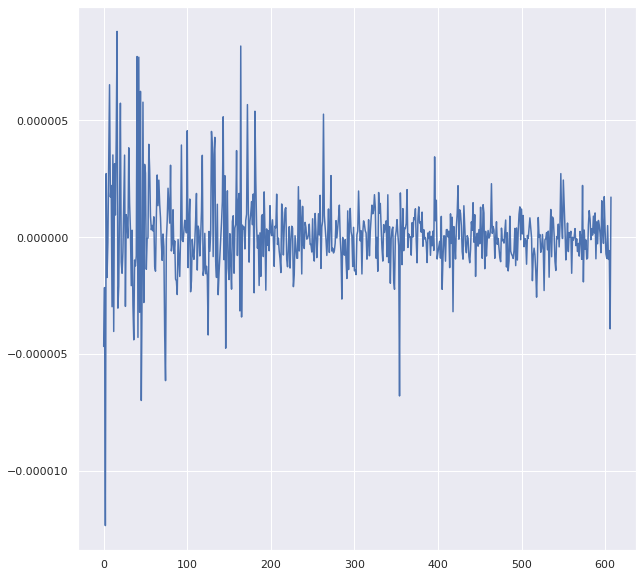

In [68]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(f.values.sum(axis=1))